# T2: Masked Bypassing
- CodeT5 Model, Wild-small^na Dataset

In [1]:
import argparse
import warnings
import os
warnings.filterwarnings(action='ignore')
from tqdm.auto import tqdm
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

import nltk.translate.bleu_score as bleu
import numpy as np
import torch
from diff_match_patch import diff_match_patch

from transformers import T5ForConditionalGeneration
from transformers import RobertaTokenizer
from transformers.tokenization_utils import PreTrainedTokenizer
from transformers import set_seed,BatchEncoding
set_seed(42)

from torch.utils.data import DataLoader
from datasets import load_dataset, DatasetDict
from typing import Any, DefaultDict, List, Dict
import pyarrow as pa
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

In [3]:
args=argparse.Namespace(
    batch_size=1, 
    size="small_noabstract", #  "medium", "small_noabstract"
    max_length = 256,
    device = "cuda",
    target_dataset="val",
    top=1,
    savefile = "temp",
    dotrain = "",
    beamsize = 5,
    trgatt = "cross" 
)
################################

# Load APR Model
# Dowonload the trained APR models from the link in the following directory
load_model_dir = f"APR Models/codet5base_wild{args.size}"
device = args.device
tokenizer = RobertaTokenizer.from_pretrained(load_model_dir)
model = T5ForConditionalGeneration.from_pretrained(load_model_dir)
model.to(args.device)
model.eval()
model.resize_token_embeddings(len(tokenizer))
print(f"Loaded from directory {load_model_dir}")

Loaded from directory APR Models_/codet5base_wildsmall_noabstract


In [4]:
#  Load dataset
if 'noabstract' in args.size:
    datasetdir = f"Dataset/{args.size}"
    
    with open(f"{datasetdir}/val.buggy-fixed.buggy","r",encoding='utf8') as f:
        inputs = f.read().split('\n')
        inputs = [x for x in inputs if x!='']
    with open(f"{datasetdir}/val.buggy-fixed.fixed","r",encoding='utf8') as f:   
        labels = f.read().split('\n')
        labels = [x for x in labels if x!='']
    val_data = dict()
    val_data['buggy']=pa.array(inputs)
    val_data['fixed']=pa.array(labels)
    
    with open(f"{datasetdir}/test.buggy-fixed.buggy","r",encoding='utf8') as f:
        inputs = f.read().split('\n')
        inputs = [x for x in inputs if x!='']
    with open(f"{datasetdir}/test.buggy-fixed.fixed","r",encoding='utf8') as f:   
        labels = f.read().split('\n')
        labels = [x for x in labels if x!='']
    test_data = dict()
    test_data['buggy']=pa.array(inputs)
    test_data['fixed']=pa.array(labels)
    
else:
    dataset = load_dataset("code_x_glue_cc_code_refinement",args.size)
    train_data = dataset.data['train']
    val_data = dataset.data['validation']
    test_data = dataset.data['test']
    print(f"#train: {train_data.num_rows}, #val: {val_data.num_rows}, #test: {test_data.num_rows}")
    print(val_data.column_names)

    if args.target_dataset=='test':
        inputs = test_data['buggy'].to_pylist()
        labels = test_data['fixed'].to_pylist()
        print("load test")
    elif args.target_dataset=='val':
        inputs = val_data['buggy'].to_pylist()
        labels = val_data['fixed'].to_pylist()
        print("load val")
    elif args.target_dataset=='train':
        inputs = train_data['buggy'].to_pylist()
        labels = train_data['fixed'].to_pylist()
        print("load train")
    else:
        print("CHECK THE ARGS.TARGET_DATASET")

## 1. Utils

In [5]:
number_of_layers, number_of_heads = 12, 12 # change according to used model

lhpairs = [(l,h) for l in range(number_of_layers) for h in range(number_of_heads)]
def get_lhresult(results, l, h):
    for line in results:
        fidx, fem, _,_,_,layer, head, _, _,_ = line
        if layer==l and head==h:
            return line

class BugFixDataset(torch.utils.data.Dataset):
    def __init__(self, encodings: BatchEncoding, targets: BatchEncoding, idxs):
        self.encodings = encodings
        self.target_encodings = targets
        self.idxs = idxs

    def __getitem__(self, index: int) -> Dict[str, Any]:
        item = {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.target_encodings["input_ids"][index], dtype=torch.long)
        item["idx"] = self.idxs[index]
        return item

    def __len__(self) -> int:
        return len(self.encodings["input_ids"])

    
def create_dataset(
    idxs: List[int],
    inputs: List[str],
    labels: List[str],
    tokenizer: PreTrainedTokenizer,
    pad_truncate: bool,
    max_length=None,
) -> BugFixDataset:

    input_encodings = tokenizer(
        inputs, truncation=pad_truncate, padding=pad_truncate, max_length=max_length
    )
    label_encodings = tokenizer(
        labels, truncation=pad_truncate, padding=pad_truncate, max_length=max_length
    )

    dataset = BugFixDataset(input_encodings, label_encodings, idxs)
    return dataset

## 2. Check the Attention Map

[Check Size of instance 3]
 1) input length:  88
 2) output length: 92
 3) normalized attention map shape: (92, 88)


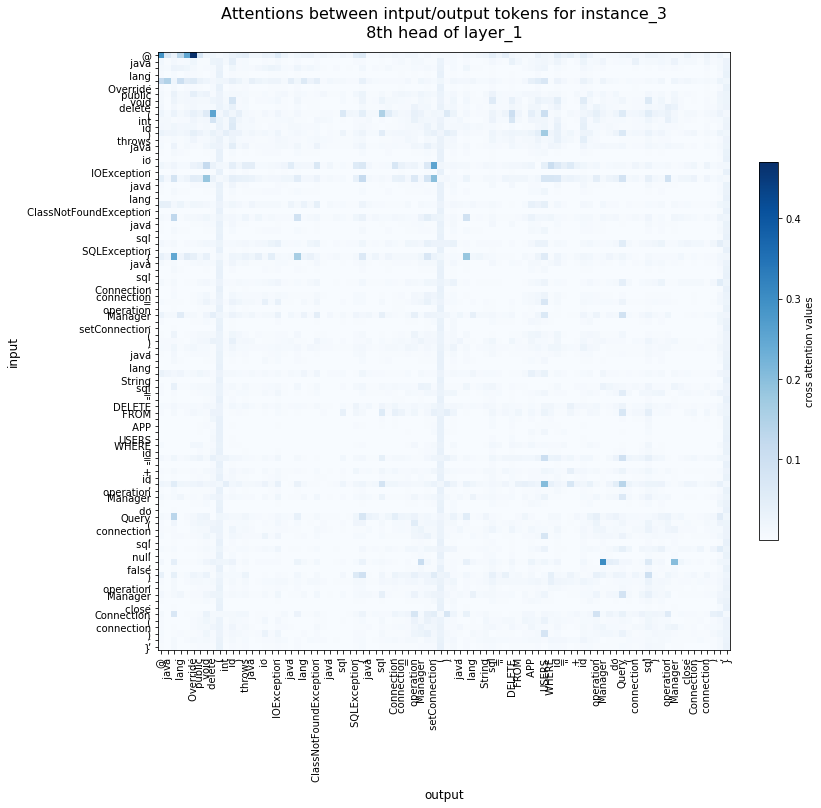

Printing attention map of whole attention heads (might take few seconds)


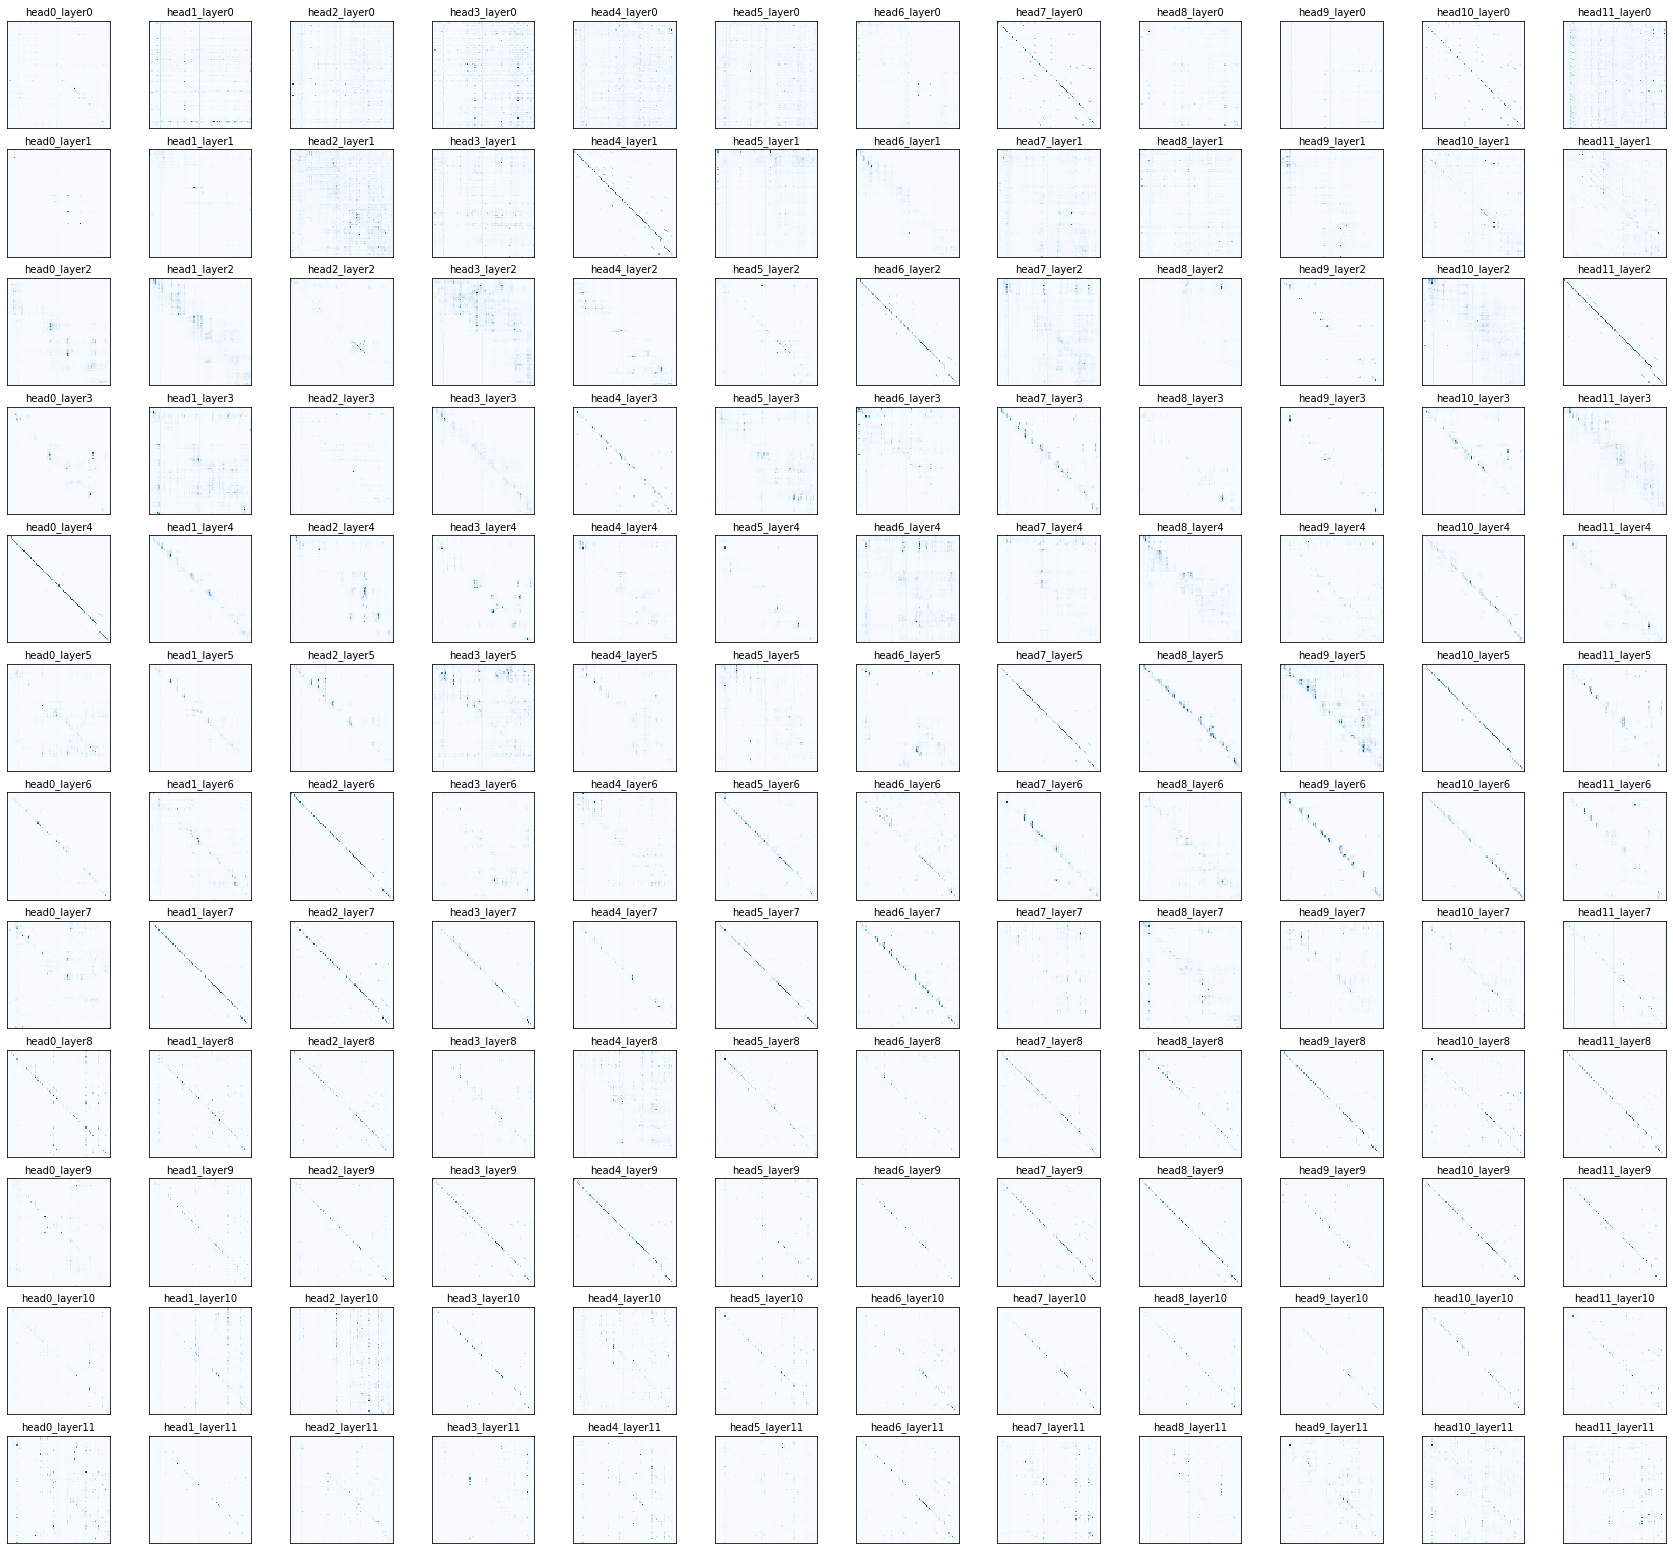

In [7]:
# Check the  Sample attention map
fileidx = 3

target_dataset = 'val'
attentiondir = f"Attentions/codet5base_wild{args.size}/{target_dataset}"
with open(f"{attentiondir}/{fileidx}.pkl","rb") as f:
    attresults = pickle.load(f)

# Check size
fidx, fem, input_id, output_id, answer_id, layer, head, vnorms, att_map, norm_map = attresults[0]
print(f"[Check Size of instance {fidx}]\n", 
      f"1) input length:  {len(input_id)}\n",
      f"2) output length: {len(output_id)}\n",
      f"3) normalized attention map shape: {norm_map.shape}")

# Visualize attention map of single attention head
hidx = 20 # sample attention head (0 ~ #layer*#head)
fidx, fem, input_id, output_id, answer_id, layer, head, vnorms, att_map, norm_map = attresults[hidx]
out_tokens = tokenizer.convert_ids_to_tokens(output_id)
in_tokens = tokenizer.convert_ids_to_tokens(input_id)
out_tokens = [tokenizer.convert_tokens_to_string(x) for x in out_tokens]
in_tokens = [tokenizer.convert_tokens_to_string(x) for x in in_tokens]

fig, ax = plt.subplots(1,1, figsize=(13,11))
ticks = [i+1 for i in range(12)]
plt.xticks(range(0,len(in_tokens)), in_tokens, rotation=90)
plt.yticks(range(0,len(out_tokens)), out_tokens)

plt.imshow(norm_map, interpolation='none', cmap='Blues')
plt.colorbar(label='cross attention values',fraction=0.026, pad=0.04)
ax.set_xlabel('output', fontsize=12)
ax.set_ylabel('input',fontsize=12)
plt.title(f'Attentions between intput/output tokens for instance_{fileidx}\n {head}th head of layer_{layer} ', fontsize=16,pad=15)
plt.show()

print("Printing attention map of whole attention heads (might take few seconds)")
# Visualize attention map of all attention heads
figs, axs = plt.subplots(number_of_layers,number_of_heads, figsize=(30,28))
for hidx in range(number_of_layers*number_of_heads):
    fidx, fem, input_id, output_id, answer_id, layer, head, vnorms, att_map, norm_map = attresults[hidx]
    axs[layer][head].imshow(norm_map, interpolation='none', cmap='Blues')
    axs[layer][head].set(yticklabels=[]) 
    axs[layer][head].tick_params(left=False)
    axs[layer][head].set(xticklabels=[]) 
    axs[layer][head].tick_params(bottom=False)
    axs[layer][head].set_title(f"head{head}_layer{layer}", fontsize=10)
plt.show()

## 3. Token type identification function

In [8]:
def get_lhresult(results, l, h):
    for line in results:
        #idxs[0], em, input_id, output_id, answer_id, layer, head, vnorms, att_map, norm_map
        fidx, fem, _,_,_,layer, head, _, _,_ = line
        if layer==l and head==h:
            return line
        
def tid2str(trg_ids):
    if type(trg_ids)==list:
        temp_ids = [str(x) for x in trg_ids]
    else:
        temp_ids = [str(x.item()) for x in trg_ids]
    temp_ids = ",".join(temp_ids)
    return temp_ids

def get_needfixloc (input_id, out_id, answer_id):
    input_idstr = tid2str(input_id)
    out_idstr = tid2str(answer_id)
        
    text1 = input_idstr.replace(',','\n')
    text2 = out_idstr.replace(',','\n')

    dmp = diff_match_patch()
    a = dmp.diff_linesToChars(text1, text2)
    lineText1, lineText2, lineArray  = a[0],a[1],a[2]
    diffs = dmp.diff_main(lineText1, lineText2, False)
    dmp.diff_charsToLines(diffs, lineArray)

    ### Location matching ###
    instart, outstart = -1, -1
    inlocs = [] # Location of  removed tokens in input
    outlocs = [] # Location of tokens added in output
    dmp.diff_cleanupSemantic(diffs)    
    for diff_idx, diff in enumerate(diffs): 
        diff_type = list(diff)[0]
        tokens = list(diff)[1].split("\n")  
        tokens = [x for x in tokens if x!='']
        if diff_type == 0:                          # 0: remain
            instart += len(tokens)
            outstart += len(tokens)
        if diff_type == 1:                          # 1: add
            for tok in tokens:
                outstart+=1
                outlocs.append(outstart)
        if diff_type == -1:                         # -1: del
            for tok in tokens:
                instart+=1
                inlocs.append(instart)
    try:
        deltokens = [input_idstr.split(',')[i] for i in inlocs]
        addtokens = [out_idstr.split(',')[i] for i in outlocs]
    except:
        return False
    
    return inlocs

## 4. Behavior Vector Representation

In [9]:
def get_lhranks (target_dataset, trg_idxs, trglocfun):
    olhranks = {f"{layer}_{head}":[] for layer in range(number_of_layers) for head in range(number_of_heads)}
    xlhranks = {f"{layer}_{head}":[] for layer in range(number_of_layers) for head in range(number_of_heads)}
    
    # To run with whole data, you should download zip file
    attentiondir = f"Attentions/codet5base_wild{args.size}/{target_dataset}"
    if len(trg_idxs)>len(os.listdir(attentiondir)):
        trg_idxs = np.arange(len(os.listdir(attentiondir)))
    
    # read pickle files
    pbar = tqdm(range(len(trg_idxs)))
    for fileidx in trg_idxs:
        with open(f"{attentiondir}/{fileidx}.pkl","rb") as f:
            attresults = pickle.load(f)
        fidx, fem, input_id, output_id, answer_id,_,_,_,_,_ = attresults[0]
        
        trglocs = trglocfun(input_id, output_id, answer_id) # Get location of the target token
        
        for layer, head in lhpairs:
            info = get_lhresult(attresults, layer, head)
            _, _, input_id, output_id, answer_id, l, h, vnorms, att_map, norm_map = info
            en_map = norm_map
            keyscores = np.sum(en_map, axis=0)
            trgscores = keyscores[trglocs]
            ratio = 100*sum(trgscores)/sum(keyscores)
            if fem==1:
                olhranks[f"{layer}_{head}"].append(ratio)
            else:
                xlhranks[f"{layer}_{head}"].append(ratio)
        pbar.update(1)
    return olhranks, xlhranks


def make_vec(target_dataset, trg_idxs, trglocfun):
    olhranks, xlhranks = get_lhranks(target_dataset, trg_idxs, trglocfun)
    #  Make Impact ratio vector
    X, Y = [],[]
    for i in range(len(olhranks["0_0"])):
        vec = []
        for layer,head in lhpairs:
            vec.append(olhranks[f"{layer}_{head}"][i])
        X.append(vec)
        Y.append(1)

    for i in range(len(xlhranks["0_0"])):
        vec = []
        for layer,head in lhpairs:
            vec.append(xlhranks[f"{layer}_{head}"][i])
        X.append(vec)
        Y.append(0)
    return X,Y

# False Behavior Vectors from APR model's validation dataset to train BeDisc
inputs = val_data['buggy'].to_pylist()
labels = val_data['fixed'].to_pylist()
valtrg_idxs = np.arange(len(inputs))
valX, valY= make_vec('val', valtrg_idxs, get_needfixloc)

newvalX, newvalY = [],[]
for X, Y in zip(valX, valY):
    if sum(X)==0:
        continue
    newvalX.append(X)
    newvalY.append(Y)

  0%|          | 0/5835 [00:00<?, ?it/s]

In [10]:
# View sample behavior vector
for i in [0,1,-1,-2]:
    fig, ax = plt.subplots(1,1, figsize=(24,3))
    ax.set(yticklabels=[newvalY[i]]) # Y tick is label (1: True Behavior, 0: False Behavior)
    ax.tick_params(left=False)
    ax.set(xticklabels=[]) 
    ax.tick_params(bottom=False)
    ax.imshow(np.array(newvalX[i]).reshape(1,-1), interpolation='none', cmap='Blues')
    plt.show()

## 5. Diagnose and apply Treatement 2
- T2 can fix more bugs: 1513 -> 1900 (+25.58%)
- The result correspond to 5th result in Table 4

In [12]:
# Searched thresholds (with validation data) for tolerance 1~5 %. Test is conducted with seperate data, which isn't used for threshold search.
thresholds = {1:(60,0.9999),
              2:(380,0.96),
              3:(380,0.94),
              4:(100,0.95),
              5:(120,0.92)}

inputs = test_data['buggy'].to_pylist()
labels = test_data['fixed'].to_pylist()
trg_idxs = np.arange(len(inputs))
target_dataset='test'
tolerance = 5
hls, thres = thresholds[tolerance]

fixresults = []
ogfix = 0

# To run with whole data, you should download zip file
attentiondir = f"Attentions/codet5base_wild{args.size}/{target_dataset}"
    
# train BeDisc with APR's validation data
clf1 = MLPClassifier(alpha=1, max_iter=1000, hidden_layer_sizes=hls,random_state=0)
clf1.fit(newvalX, newvalY)

# Diagnose and Treat
pbar=tqdm(range(len(trg_idxs)))
for fileidx in trg_idxs:
    with open(f"{attentiondir}/{fileidx}.pkl","rb") as f:
        attresults = pickle.load(f)
    fidx, fem, input_id, output_id, answer_id,_,_,_,_,_ = attresults[0]

    # performance without proposed method
    ogfix+=fem

    inlocs = get_needfixloc(input_id, output_id, answer_id)
    # inputs for APR model
    input_id=[1]+input_id+[2]
    attmask = np.ones(len(input_id))
    input_id = torch.tensor([input_id])
    attmask = torch.tensor([attmask])
    # result of APR model
    isFixed = False

    # If no target token identified, use original model's result. Do not progress to further stage.
    if not inlocs:
        output = model.generate(input_ids=input_id.to(args.device), attention_mask=attmask.to(args.device),
                            num_beams=5, max_length=args.max_length
                           )
        output = output[0][2:-1]
        answer = tokenizer.decode(answer_id)
        output = tokenizer.decode(output)
        weight = (0.25, 0.25, 0.25, 0.25)
        score = bleu.sentence_bleu([output.split()], answer.split(), weight, auto_reweigh=True)
        if score==1:
            isFixed = True

        if fem==0 and score==1:
            print(fileidx, 0, 1)
        elif fem==1 and score!=1:
            print(fileidx, 1, 0)

        fixresults.append(isFixed)
        pbar.update(1)
        continue

    # Behavior vector representation
    clfvec = []
    for layer, head in lhpairs:
        info = get_lhresult(attresults, layer, head)
        _, _, _, _, _, l, h, vnorms, att_map, norm_map = info
        en_map = norm_map
        keyscores = np.sum(en_map, axis=0)
        trgscores = keyscores[inlocs]
        ratio = 100*sum(trgscores)/sum(keyscores)
        clfvec.append(ratio)

    # False Detection
    prob = clf1.predict_proba([clfvec])[0]
    if prob[0]>thres:
        Dprediction=False
    else:
        Dprediction=True

    # Diagnosed as False, progress to treatment stage
    if Dprediction==False:
        # T2: Masked Bypassing 
        meta = inlocs
        attmask = np.ones(len(input_id[0]))
        for idloc in meta:
            attmask[idloc+1]=0
        attmask = torch.tensor([attmask])
        output = model.generate(input_ids=input_id.to(args.device), attention_mask=attmask.to(args.device),
                                num_beams=5, max_length=args.max_length
                               )

    # Diagnosed as True, use the original model
    else:
        output = model.generate(input_ids=input_id.to(args.device), attention_mask=attmask.to(args.device),
                                num_beams=5, max_length=args.max_length
                               )


    output = output[0][2:-1]
    answer = tokenizer.decode(answer_id)
    output = tokenizer.decode(output)
    weight = (0.25, 0.25, 0.25, 0.25)
    score = bleu.sentence_bleu([output.split()], answer.split(), weight, auto_reweigh=True)
    if score==1:
        isFixed=True

    fixresults.append(isFixed)

    print(fileidx, fem, isFixed, ogfix, sum(fixresults), Dprediction, sep='\t')
    pbar.update(1)

  0%|          | 0/5835 [00:00<?, ?it/s]

0	0	False	0	0	False
1	0	False	0	0	False
2	0	False	0	0	False
3	1	True	1	1	True
4	0	False	1	1	False
5	1	True	2	2	True
6	1	True	3	3	True
7	0	True	3	4	False
8	0	True	3	5	False
9	0	True	3	6	False
10	1	True	4	7	True
11	0	False	4	7	True
12	0	False	4	7	False
13	1	True	5	8	False
14	1	True	6	9	True
15	0	False	6	9	False
16	0	True	6	10	False
18	1	True	7	11	True
20	0	True	7	12	False
21	0	False	7	12	False
22	1	True	8	13	True
23	0	False	8	13	True
24	0	True	8	14	False
25	0	False	8	14	True
26	0	True	8	15	False
28	1	True	10	17	False
29	0	False	10	17	False
30	0	False	10	17	False
31	0	False	10	17	False
32	1	True	11	18	False
33	1	True	12	19	True
35	0	False	12	19	False
36	0	False	12	19	False
37	1	True	13	20	True
38	0	False	13	20	False
39	0	False	13	20	False
40	0	False	13	20	False
41	1	True	14	21	True
43	0	True	14	22	False
45	0	False	14	22	False
46	1	True	15	23	True
47	0	False	15	23	False
48	0	False	15	23	True
49	0	False	15	23	False
50	0	False	15	23	False
51	1	True	16	24	True
52	0	False	16	24	True
54	0	False

442	1	True	125	154	True
443	1	False	126	154	False
444	1	True	127	155	True
445	0	False	127	155	True
446	0	False	127	155	False
447	0	False	127	155	False
450	0	False	128	156	False
451	0	False	128	156	False
452	0	False	128	156	False
455	0	False	128	156	False
456	0	False	128	156	False
457	0	False	128	156	False
458	0	False	128	156	False
459	0	False	128	156	False
460	0	False	128	156	False
461	1	True	129	157	True
464	0	False	130	158	False
465	0	False	130	158	False
467	0	False	131	159	False
468	0	False	131	159	False
469	0	False	131	159	False
470	0	False	131	159	False
471	0	False	131	159	False
472	0	False	131	159	False
473	0	False	131	159	False
475	0	False	131	159	False
477	0	False	131	159	False
478	0	False	131	159	False
479	0	False	131	159	False
480	0	False	131	159	False
482	1	True	133	161	True
483	0	False	133	161	True
487	1	True	135	163	True
488	0	False	135	163	False
489	0	False	135	163	False
490	0	False	135	163	False
491	0	False	135	163	False
492	0	False	135	163	True
495	0	True	136	165	False


882	0	False	228	293	False
883	1	True	229	294	True
885	1	True	230	295	True
886	0	False	230	295	False
889	0	True	231	297	False
890	0	False	231	297	False
891	0	False	231	297	False
892	0	True	231	298	False
893	1	True	232	299	True
894	0	False	232	299	False
895	1	False	233	299	False
896	0	False	233	299	False
897	0	True	233	300	False
898	0	False	233	300	True
899	1	True	234	301	True
900	0	False	234	301	False
901	0	False	234	301	False
902	0	False	234	301	True
903	1	True	235	302	True
904	0	False	235	302	False
905	0	False	235	302	False
906	1	True	236	303	True
907	0	True	236	304	False
908	0	False	236	304	False
909	1	True	237	305	True
910	0	False	237	305	False
911	1	True	238	306	True
912	0	False	238	306	True
913	1	False	239	306	False
914	0	False	239	306	False
915	0	False	239	306	False
917	0	False	239	306	False
918	0	False	239	306	False
919	0	False	239	306	False
920	1	True	240	307	True
922	0	False	241	308	False
923	1	True	242	309	False
924	0	False	242	309	False
925	1	True	243	310	True
926	0	False	24

1268	0	False	338	416	False
1269	0	False	338	416	False
1270	1	False	339	416	False
1271	1	True	340	417	True
1272	1	True	341	418	True
1275	0	True	342	420	False
1276	1	True	343	421	True
1277	0	False	343	421	False
1278	1	True	344	422	True
1279	0	False	344	422	False
1281	0	True	344	423	False
1282	0	True	344	424	True
1283	0	False	344	424	False
1284	1	True	345	425	True
1285	0	False	345	425	False
1286	0	False	345	425	False
1287	0	False	345	425	False
1289	0	False	346	426	False
1290	0	False	346	426	False
1291	0	False	346	426	False
1292	1	True	347	427	True
1293	0	False	347	427	False
1294	1	True	348	428	True
1295	0	False	348	428	True
1296	0	False	348	428	True
1299	0	False	348	428	False
1300	0	False	348	428	False
1302	1	True	349	429	True
1306	0	False	349	429	False
1307	1	True	350	430	True
1308	0	True	350	431	False
1309	0	True	350	432	False
1310	1	True	351	433	True
1311	0	False	351	433	True
1312	0	False	351	433	False
1314	1	True	352	434	True
1315	0	False	352	434	False
1316	0	False	352	434	False
1317	

1665	0	False	458	558	False
1669	0	False	459	559	False
1670	0	True	459	560	False
1671	0	False	459	560	False
1672	1	True	460	561	True
1673	0	False	460	561	True
1675	0	False	460	561	False
1676	0	True	460	562	False
1677	0	False	460	562	True
1678	0	False	460	562	False
1679	0	False	460	562	False
1680	1	True	461	563	True
1681	1	True	462	564	True
1683	1	True	463	565	False
1685	0	True	463	566	False
1686	0	False	463	566	False
1687	0	True	463	567	False
1688	0	True	463	568	False
1689	0	True	463	569	False
1690	0	False	463	569	True
1691	0	False	463	569	False
1693	1	True	464	570	True
1696	0	True	465	572	False
1697	0	True	465	573	False
1699	0	False	465	573	False
1701	0	True	465	574	False
1702	0	True	465	575	False
1703	0	False	465	575	False
1704	1	True	466	576	True
1705	1	True	467	577	True
1709	0	False	467	577	False
1711	1	False	468	577	False
1712	1	True	469	578	True
1713	0	False	469	578	False
1715	0	False	469	578	False
1716	0	True	469	579	False
1718	0	False	469	579	True
1719	0	False	469	579	False
1720

2073	1	False	553	684	False
2074	0	False	553	684	False
2075	0	False	553	684	True
2077	0	False	553	684	False
2079	0	False	554	685	True
2081	0	False	555	686	False
2082	0	True	555	687	False
2083	0	False	555	687	True
2084	1	True	556	688	True
2085	1	True	557	689	True
2086	0	True	557	690	False
2087	0	True	557	691	False
2088	1	True	558	692	True
2090	1	True	559	693	True
2091	0	False	559	693	True
2092	1	True	560	694	True
2093	0	True	560	695	False
2094	1	True	561	696	True
2095	0	False	561	696	False
2096	0	False	561	696	False
2097	0	True	561	697	False
2098	0	False	561	697	False
2101	0	False	561	697	False
2103	1	True	562	698	True
2104	0	False	562	698	True
2105	1	True	563	699	True
2106	1	True	564	700	True
2107	0	False	564	700	True
2109	0	True	564	701	False
2110	0	False	564	701	False
2111	0	False	564	701	False
2112	1	True	565	702	True
2113	0	False	565	702	False
2114	0	False	565	702	False
2115	1	True	566	703	True
2116	1	True	567	704	True
2118	0	False	567	704	False
2119	0	True	567	705	False
2120	0	Fals

2456	1	True	656	821	True
2457	1	True	657	822	True
2458	1	True	658	823	True
2459	1	True	659	824	True
2460	0	False	659	824	False
2461	1	True	660	825	True
2463	0	False	660	825	False
2464	0	False	660	825	False
2465	0	False	660	825	True
2467	0	False	660	825	False
2468	0	False	660	825	False
2469	0	False	660	825	False
2471	0	True	660	826	False
2472	1	True	661	827	True
2473	0	False	661	827	False
2474	0	False	661	827	True
2475	1	True	662	828	True
2476	0	False	662	828	True
2477	0	False	662	828	False
2478	1	False	663	828	False
2479	1	True	664	829	True
2480	0	False	664	829	False
2481	0	False	664	829	False
2482	0	True	664	830	False
2483	0	False	664	830	False
2484	0	False	664	830	False
2486	0	False	664	830	False
2487	1	True	665	831	True
2488	1	True	666	832	True
2489	1	True	667	833	True
2490	1	True	668	834	True
2491	0	False	668	834	False
2492	0	False	668	834	False
2493	0	False	668	834	False
2496	0	False	668	834	False
2497	0	False	668	834	False
2498	0	True	668	835	False
2499	0	False	668	835	False
2500

2847	0	False	748	938	True
2849	0	False	749	939	False
2850	0	False	749	939	False
2851	0	False	749	939	True
2852	0	False	749	939	False
2853	1	True	750	940	True
2855	0	False	750	940	False
2856	1	True	751	941	True
2857	0	False	751	941	True
2858	0	False	751	941	False
2860	0	False	751	941	False
2861	0	False	751	941	False
2862	0	False	751	941	False
2863	1	True	752	942	True
2864	0	False	752	942	False
2865	0	False	752	942	False
2866	1	True	753	943	True
2867	0	False	753	943	False
2868	1	True	754	944	True
2869	0	False	754	944	False
2870	0	False	754	944	False
2872	1	True	755	945	True
2873	1	True	756	946	True
2874	0	False	756	946	False
2875	0	False	756	946	False
2876	1	True	757	947	True
2877	0	False	757	947	False
2878	0	False	757	947	True
2879	0	False	757	947	True
2880	1	True	758	948	True
2881	0	False	758	948	False
2882	1	True	759	949	True
2883	0	False	759	949	False
2884	0	False	759	949	False
2885	0	False	759	949	False
2886	0	False	759	949	False
2887	0	False	759	949	False
2890	0	False	759	949	False

3231	0	False	836	1043	False
3232	1	True	837	1044	True
3233	1	True	838	1045	True
3234	1	True	839	1046	True
3235	1	True	840	1047	True
3237	0	False	840	1047	False
3238	1	True	841	1048	True
3239	0	False	841	1048	False
3240	0	False	841	1048	False
3241	0	False	841	1048	True
3242	0	False	841	1048	False
3243	1	True	842	1049	True
3244	0	False	842	1049	False
3245	1	True	843	1050	True
3246	0	False	843	1050	False
3247	0	False	843	1050	False
3248	0	False	843	1050	False
3249	0	False	843	1050	False
3250	1	True	844	1051	True
3251	1	True	845	1052	True
3252	0	False	845	1052	False
3253	0	True	845	1053	False
3255	1	True	846	1054	True
3256	0	True	846	1055	False
3257	0	False	846	1055	False
3258	0	False	846	1055	False
3259	1	True	847	1056	True
3260	0	False	847	1056	False
3261	0	False	847	1056	False
3262	0	False	847	1056	True
3263	1	True	848	1057	True
3265	0	False	849	1058	False
3266	0	False	849	1058	False
3267	1	True	850	1059	True
3269	1	True	851	1060	True
3271	0	True	851	1061	False
3272	1	True	852	1062	True

3604	0	True	943	1184	False
3605	1	True	944	1185	False
3606	1	True	945	1186	True
3608	0	False	945	1186	False
3609	0	True	945	1187	False
3611	0	False	945	1187	False
3612	0	False	945	1187	False
3613	1	True	946	1188	True
3615	0	False	946	1188	False
3616	0	False	946	1188	False
3617	0	False	946	1188	False
3619	0	False	946	1188	False
3620	1	True	947	1189	True
3621	0	False	947	1189	True
3622	0	False	947	1189	False
3623	0	True	947	1190	False
3624	0	False	947	1190	True
3626	1	True	948	1191	True
3627	0	False	948	1191	True
3628	0	False	948	1191	False
3629	0	False	948	1191	False
3630	1	True	949	1192	True
3631	0	False	949	1192	False
3632	0	False	949	1192	False
3633	0	False	949	1192	False
3634	1	True	950	1193	True
3635	0	True	950	1194	False
3636	0	False	950	1194	False
3637	0	False	950	1194	True
3638	0	False	950	1194	False
3639	0	False	950	1194	False
3640	1	True	951	1195	True
3641	1	True	952	1196	True
3642	0	False	952	1196	False
3643	0	False	952	1196	False
3644	0	False	952	1196	False
3645	1	True	953	1

3976	0	False	1034	1299	False
3978	0	False	1035	1300	True
3979	0	False	1035	1300	False
3980	0	False	1035	1300	False
3981	0	False	1035	1300	False
3982	0	False	1035	1300	True
3983	0	False	1035	1300	False
3984	0	False	1035	1300	False
3985	0	False	1035	1300	True
3986	0	True	1035	1301	False
3987	0	False	1035	1301	False
3989	0	True	1035	1302	False
3990	1	True	1036	1303	True
3991	0	False	1036	1303	False
3992	0	False	1036	1303	False
3993	0	False	1036	1303	False
3994	0	False	1036	1303	True
3996	0	False	1037	1304	False
3998	0	False	1037	1304	False
3999	0	False	1037	1304	False
4002	0	False	1037	1304	True
4003	0	False	1037	1304	True
4004	0	False	1037	1304	False
4006	1	True	1038	1305	True
4007	0	False	1038	1305	False
4009	1	True	1039	1306	True
4010	0	False	1039	1306	True
4011	0	True	1039	1307	False
4012	0	False	1039	1307	False
4013	1	True	1040	1308	True
4014	0	False	1040	1308	False
4015	0	False	1040	1308	True
4016	1	True	1041	1309	True
4017	0	False	1041	1309	False
4018	0	True	1041	1310	False
4020	1	

4333	1	True	1125	1411	True
4335	1	True	1126	1412	True
4337	0	False	1126	1412	False
4338	0	False	1126	1412	False
4339	0	False	1126	1412	False
4340	0	False	1126	1412	False
4341	0	False	1126	1412	True
4342	1	True	1127	1413	True
4346	0	False	1128	1414	False
4347	1	True	1129	1415	True
4348	0	False	1129	1415	False
4350	1	True	1131	1417	True
4351	0	False	1131	1417	True
4352	0	True	1131	1418	False
4353	0	False	1131	1418	False
4354	1	True	1132	1419	True
4355	0	False	1132	1419	False
4359	0	False	1132	1419	False
4361	0	False	1132	1419	False
4363	0	True	1132	1420	False
4364	1	True	1133	1421	True
4366	0	False	1134	1422	False
4370	0	False	1134	1422	False
4373	1	True	1135	1423	True
4374	0	True	1135	1424	False
4375	0	False	1135	1424	False
4376	1	True	1136	1425	True
4378	0	False	1136	1425	False
4379	0	False	1136	1425	False
4380	0	False	1136	1425	True
4381	0	True	1136	1426	False
4383	0	False	1136	1426	False
4384	0	False	1136	1426	False
4385	1	True	1137	1427	True
4386	0	False	1137	1427	False
4387	0	False

4716	1	True	1215	1530	True
4718	0	False	1216	1531	False
4719	0	False	1216	1531	False
4720	0	True	1216	1532	False
4721	1	True	1217	1533	True
4722	0	False	1217	1533	True
4723	0	True	1217	1534	False
4724	0	False	1217	1534	False
4725	1	True	1218	1535	True
4726	0	False	1218	1535	False
4727	0	False	1218	1535	False
4728	0	False	1218	1535	False
4729	0	False	1218	1535	False
4731	1	True	1219	1536	True
4732	0	False	1219	1536	True
4733	1	True	1220	1537	True
4735	1	True	1222	1539	True
4736	0	False	1222	1539	True
4737	0	False	1222	1539	False
4738	0	False	1222	1539	False
4739	0	False	1222	1539	False
4740	0	False	1222	1539	False
4742	0	True	1222	1540	False
4743	1	True	1223	1541	True
4746	0	False	1224	1542	False
4747	1	True	1225	1543	True
4748	0	False	1225	1543	False
4749	0	False	1225	1543	False
4751	0	False	1226	1544	False
4752	0	False	1226	1544	False
4753	0	False	1226	1544	False
4754	0	False	1226	1544	False
4755	1	False	1227	1544	False
4756	0	True	1227	1545	False
4759	1	True	1229	1547	True
4760	0	Fal

5081	0	False	1317	1652	False
5082	0	False	1317	1652	True
5083	0	False	1317	1652	False
5084	0	False	1317	1652	False
5085	0	False	1317	1652	False
5086	0	False	1317	1652	False
5088	0	True	1317	1653	False
5089	0	False	1317	1653	False
5091	1	True	1318	1654	True
5093	0	False	1318	1654	False
5094	0	False	1318	1654	False
5095	1	True	1319	1655	True
5097	1	True	1320	1656	True
5100	0	False	1320	1656	True
5101	1	True	1321	1657	True
5102	0	False	1321	1657	False
5103	0	True	1321	1658	False
5104	0	False	1321	1658	True
5105	0	False	1321	1658	False
5106	0	False	1321	1658	False
5108	0	False	1321	1658	False
5109	0	False	1321	1658	False
5110	0	True	1321	1659	False
5111	1	True	1322	1660	True
5112	0	False	1322	1660	False
5113	0	False	1322	1660	False
5116	0	False	1322	1660	False
5117	0	True	1322	1661	False
5118	0	False	1322	1661	False
5119	1	True	1323	1662	True
5120	1	True	1324	1663	True
5122	0	False	1324	1663	False
5123	0	False	1324	1663	False
5125	0	False	1324	1663	False
5126	0	False	1324	1663	False
5127	0

5461	0	True	1414	1777	False
5462	1	True	1415	1778	True
5463	1	False	1416	1778	False
5464	0	False	1416	1778	True
5466	0	False	1416	1778	False
5468	0	False	1416	1778	False
5469	0	False	1416	1778	False
5470	1	True	1417	1779	True
5472	0	False	1417	1779	True
5475	1	True	1418	1780	True
5476	0	False	1418	1780	False
5478	1	True	1419	1781	True
5479	0	False	1419	1781	False
5482	0	False	1419	1781	False
5483	0	False	1419	1781	False
5484	0	False	1419	1781	False
5485	1	True	1420	1782	True
5486	1	True	1421	1783	True
5488	1	True	1422	1784	True
5489	0	False	1422	1784	False
5490	0	False	1422	1784	False
5492	1	True	1424	1786	True
5493	0	False	1424	1786	False
5494	1	True	1425	1787	True
5495	0	False	1425	1787	False
5496	0	False	1425	1787	False
5497	0	False	1425	1787	False
5498	1	False	1426	1787	False
5499	0	False	1426	1787	True
5500	1	True	1427	1788	True
5501	0	True	1427	1789	False
5502	0	False	1427	1789	False
5503	0	False	1427	1789	False
5505	0	True	1427	1790	False
5506	0	False	1427	1790	False
5507	0	Fals

## 6. Comparison: Mask target token without diagnose
- Ignorantly applying masked bypassing to every instance without proper diagnosis leads to degradation: 1519 -> 1271 (-16%)
- The result corresponds to 5th result of "w/o BeDisc, w Mask" column in the Table 4

In [33]:
inputs = test_data['buggy'].to_pylist()
labels = test_data['fixed'].to_pylist()
trg_idxs = np.arange(len(inputs))
target_dataset='test'

cfixresults = []
ogfix = 0

# To run with whole data, you should download zip file
attentiondir = f"Attentions/codet5base_wild{args.size}/{target_dataset}"

# Diagnose and Treat
pbar=tqdm(range(len(trg_idxs)))
for fileidx in trg_idxs:
    with open(f"{attentiondir}/{fileidx}.pkl","rb") as f:
        attresults = pickle.load(f)
    fidx, fem, input_id, output_id, answer_id,_,_,_,_,_ = attresults[0]

    # performance without proposed method
    ogfix+=fem

    inlocs = get_needfixloc(input_id, output_id, answer_id)
    # inputs for APR model
    input_id=[1]+input_id+[2]
    attmask = np.ones(len(input_id))
    input_id = torch.tensor([input_id])
    attmask = torch.tensor([attmask])
    # result of APR model
    isFixed = False

    # If no target token identified, use original model's result. Don't mask anything
    if not inlocs:
        output = model.generate(input_ids=input_id.to(args.device), attention_mask=attmask.to(args.device),
                            num_beams=5, max_length=args.max_length
                           )
    # Mask the target input
    else:
        meta = inlocs
        attmask = np.ones(len(input_id[0]))
        for idloc in meta:
            attmask[idloc+1]=0
        attmask = torch.tensor([attmask])
        output = model.generate(input_ids=input_id.to(args.device), attention_mask=attmask.to(args.device),
                                num_beams=5, max_length=args.max_length
                               )

    output = output[0][2:-1]
    answer = tokenizer.decode(answer_id)
    output = tokenizer.decode(output)
    weight = (0.25, 0.25, 0.25, 0.25)
    score = bleu.sentence_bleu([output.split()], answer.split(), weight, auto_reweigh=True)
    if score==1:
        isFixed=True

    cfixresults.append(isFixed)

    print(fileidx, fem, isFixed, ogfix, sum(cfixresults), Dprediction, sep='\t')
    pbar.update(1)

  0%|          | 0/5835 [00:00<?, ?it/s]

0	0	False	0	0	True
1	0	False	0	0	True
2	0	False	0	0	True
3	1	False	1	0	True
4	0	False	1	0	True
5	1	True	2	1	True
6	1	False	3	1	True
7	0	True	3	2	True
8	0	True	3	3	True
9	0	True	3	4	True
10	1	False	4	4	True
11	0	False	4	4	True
12	0	False	4	4	True
13	1	True	5	5	True
14	1	True	6	6	True
15	0	False	6	6	True
16	0	True	6	7	True
17	0	False	6	7	True
18	1	False	7	7	True
19	0	False	7	7	True
20	0	True	7	8	True
21	0	False	7	8	True
22	1	True	8	9	True
23	0	False	8	9	True
24	0	True	8	10	True
25	0	False	8	10	True
26	0	True	8	11	True
27	1	True	9	12	True
28	1	True	10	13	True
29	0	False	10	13	True
30	0	False	10	13	True
31	0	False	10	13	True
32	1	True	11	14	True
33	1	True	12	15	True
34	0	False	12	15	True
35	0	False	12	15	True
36	0	False	12	15	True
37	1	True	13	16	True
38	0	False	13	16	True
39	0	False	13	16	True
40	0	False	13	16	True
41	1	False	14	16	True
42	0	False	14	16	True
43	0	True	14	17	True
44	0	False	14	17	True
45	0	False	14	17	True
46	1	False	15	17	True
47	0	False	15	17	True
48	0	False	15	17	True
4

367	0	False	103	83	True
368	1	True	104	84	True
369	0	False	104	84	True
370	0	False	104	84	True
371	0	False	104	84	True
372	0	True	104	85	True
373	0	False	104	85	True
374	0	False	104	85	True
375	0	True	104	86	True
376	1	False	105	86	True
377	0	False	105	86	True
378	1	True	106	87	True
379	0	False	106	87	True
380	0	True	106	88	True
381	0	False	106	88	True
382	0	False	106	88	True
383	0	False	106	88	True
384	0	True	106	89	True
385	0	False	106	89	True
386	0	False	106	89	True
387	0	False	106	89	True
388	0	False	106	89	True
389	0	False	106	89	True
390	1	True	107	90	True
391	1	True	108	91	True
392	0	False	108	91	True
393	0	False	108	91	True
394	1	True	109	92	True
395	1	False	110	92	True
396	0	False	110	92	True
397	1	False	111	92	True
398	0	True	111	93	True
399	0	False	111	93	True
400	1	False	112	93	True
401	1	False	113	93	True
402	1	True	114	94	True
403	0	False	114	94	True
404	0	False	114	94	True
405	0	False	114	94	True
406	0	False	114	94	True
407	0	False	114	94	True
408	0	False	114	94	True
409

701	0	False	192	155	True
702	1	False	193	155	True
703	0	False	193	155	True
704	0	False	193	155	True
705	0	False	193	155	True
706	0	False	193	155	True
707	0	False	193	155	True
708	1	False	194	155	True
709	0	False	194	155	True
710	0	False	194	155	True
711	0	False	194	155	True
712	0	False	194	155	True
713	0	False	194	155	True
714	0	False	194	155	True
715	0	False	194	155	True
716	0	False	194	155	True
717	0	False	194	155	True
718	0	True	194	156	True
719	0	False	194	156	True
720	0	False	194	156	True
721	0	False	194	156	True
722	0	False	194	156	True
723	0	True	194	157	True
724	0	False	194	157	True
725	0	False	194	157	True
726	0	True	194	158	True
727	0	False	194	158	True
728	0	False	194	158	True
729	0	True	194	159	True
730	0	False	194	159	True
731	1	False	195	159	True
732	0	False	195	159	True
733	0	True	195	160	True
734	0	False	195	160	True
735	0	False	195	160	True
736	1	True	196	161	True
737	0	False	196	161	True
738	0	False	196	161	True
739	0	False	196	161	True
740	0	False	196	161	True
741	0	

1031	0	False	278	231	True
1032	0	False	278	231	True
1033	0	False	278	231	True
1034	0	False	278	231	True
1035	1	False	279	231	True
1036	0	False	279	231	True
1037	0	False	279	231	True
1038	0	False	279	231	True
1039	0	False	279	231	True
1040	0	False	279	231	True
1041	0	False	279	231	True
1042	0	False	279	231	True
1043	0	False	279	231	True
1044	0	False	279	231	True
1045	0	False	279	231	True
1046	0	False	279	231	True
1047	1	True	280	232	True
1048	1	True	281	233	True
1049	1	True	282	234	True
1050	1	True	283	235	True
1051	0	False	283	235	True
1052	0	False	283	235	True
1053	0	False	283	235	True
1054	0	False	283	235	True
1055	0	True	283	236	True
1056	0	False	283	236	True
1057	0	False	283	236	True
1058	0	True	283	237	True
1059	1	True	284	238	True
1060	0	False	284	238	True
1061	1	True	285	239	True
1062	0	False	285	239	True
1063	0	False	285	239	True
1064	0	False	285	239	True
1065	1	False	286	239	True
1066	0	False	286	239	True
1067	1	False	287	239	True
1068	0	False	287	239	True
1069	0	True	287	240	

1349	1	False	364	297	True
1350	1	False	365	297	True
1351	0	False	365	297	True
1352	1	True	366	298	True
1353	0	False	366	298	True
1354	1	True	367	299	True
1355	1	False	368	299	True
1356	0	False	368	299	True
1357	0	False	368	299	True
1358	1	False	369	299	True
1359	0	False	369	299	True
1360	0	False	369	299	True
1361	0	False	369	299	True
1362	0	True	369	300	True
1363	1	True	370	301	True
1364	0	False	370	301	True
1365	0	True	370	302	True
1366	1	True	371	303	True
1367	0	False	371	303	True
1368	1	True	372	304	True
1369	0	False	372	304	True
1370	0	False	372	304	True
1371	0	False	372	304	True
1372	1	True	373	305	True
1373	0	False	373	305	True
1374	0	False	373	305	True
1375	0	False	373	305	True
1376	0	True	373	306	True
1377	1	True	374	307	True
1378	0	False	374	307	True
1379	0	True	374	308	True
1380	0	False	374	308	True
1381	0	False	374	308	True
1382	0	False	374	308	True
1383	0	False	374	308	True
1384	0	False	374	308	True
1385	0	False	374	308	True
1386	0	True	374	309	True
1387	1	False	375	309	Tru

1667	0	False	459	370	True
1668	0	False	459	370	True
1669	0	False	459	370	True
1670	0	True	459	371	True
1671	0	False	459	371	True
1672	1	False	460	371	True
1673	0	False	460	371	True
1674	0	False	460	371	True
1675	0	False	460	371	True
1676	0	True	460	372	True
1677	0	False	460	372	True
1678	0	False	460	372	True
1679	0	False	460	372	True
1680	1	False	461	372	True
1681	1	True	462	373	True
1682	0	False	462	373	True
1683	1	True	463	374	True
1684	0	False	463	374	True
1685	0	True	463	375	True
1686	0	False	463	375	True
1687	0	True	463	376	True
1688	0	True	463	377	True
1689	0	True	463	378	True
1690	0	False	463	378	True
1691	0	False	463	378	True
1692	0	False	463	378	True
1693	1	False	464	378	True
1694	0	False	464	378	True
1695	1	True	465	379	True
1696	0	True	465	380	True
1697	0	True	465	381	True
1698	0	False	465	381	True
1699	0	False	465	381	True
1700	0	False	465	381	True
1701	0	True	465	382	True
1702	0	True	465	383	True
1703	0	False	465	383	True
1704	1	False	466	383	True
1705	1	True	467	384	True


1985	1	False	537	442	True
1986	1	False	538	442	True
1987	1	True	539	443	True
1988	1	False	540	443	True
1989	0	True	540	444	True
1990	0	False	540	444	True
1991	0	False	540	444	True
1992	0	False	540	444	True
1993	1	False	541	444	True
1994	0	True	541	445	True
1995	0	False	541	445	True
1996	0	False	541	445	True
1997	0	False	541	445	True
1998	0	False	541	445	True
1999	0	False	541	445	True
2000	0	False	541	445	True
2001	0	False	541	445	True
2002	0	False	541	445	True
2003	1	True	542	446	True
2004	1	True	543	447	True
2005	0	False	543	447	True
2006	0	True	543	448	True
2007	1	True	544	449	True
2008	0	False	544	449	True
2009	0	True	544	450	True
2010	0	True	544	451	True
2011	0	False	544	451	True
2012	0	False	544	451	True
2013	0	False	544	451	True
2014	0	False	544	451	True
2015	0	False	544	451	True
2016	0	False	544	451	True
2017	0	False	544	451	True
2018	1	False	545	451	True
2019	0	False	545	451	True
2020	0	False	545	451	True
2021	0	True	545	452	True
2022	1	False	546	452	True
2023	0	False	546	452	T

2303	0	False	608	510	True
2304	0	True	608	511	True
2305	1	False	609	511	True
2306	0	False	609	511	True
2307	1	True	610	512	True
2308	0	False	610	512	True
2309	0	False	610	512	True
2310	0	False	610	512	True
2311	0	False	610	512	True
2312	0	False	610	512	True
2313	0	False	610	512	True
2314	0	False	610	512	True
2315	0	False	610	512	True
2316	1	False	611	512	True
2317	0	False	611	512	True
2318	1	True	612	513	True
2319	1	False	613	513	True
2320	1	False	614	513	True
2321	0	True	614	514	True
2322	0	False	614	514	True
2323	0	False	614	514	True
2324	0	False	614	514	True
2325	0	True	614	515	True
2326	0	False	614	515	True
2327	1	False	615	515	True
2328	1	True	616	516	True
2329	1	False	617	516	True
2330	0	False	617	516	True
2331	0	False	617	516	True
2332	0	True	617	517	True
2333	0	False	617	517	True
2334	0	False	617	517	True
2335	0	True	617	518	True
2336	1	False	618	518	True
2337	0	False	618	518	True
2338	1	True	619	519	True
2339	0	False	619	519	True
2340	0	False	619	519	True
2341	0	False	619	519	

2621	1	True	695	585	True
2622	0	False	695	585	True
2623	1	False	696	585	True
2624	0	False	696	585	True
2625	0	False	696	585	True
2626	0	False	696	585	True
2627	0	True	696	586	True
2628	0	False	696	586	True
2629	0	False	696	586	True
2630	0	True	696	587	True
2631	0	False	696	587	True
2632	0	False	696	587	True
2633	0	False	696	587	True
2634	0	False	696	587	True
2635	0	False	696	587	True
2636	1	False	697	587	True
2637	0	False	697	587	True
2638	1	False	698	587	True
2639	1	False	699	587	True
2640	1	False	700	587	True
2641	0	False	700	587	True
2642	0	False	700	587	True
2643	1	True	701	588	True
2644	0	False	701	588	True
2645	1	False	702	588	True
2646	0	False	702	588	True
2647	0	False	702	588	True
2648	0	False	702	588	True
2649	1	False	703	588	True
2650	0	False	703	588	True
2651	1	False	704	588	True
2652	1	False	705	588	True
2653	1	False	706	588	True
2654	0	False	706	588	True
2655	0	False	706	588	True
2656	0	False	706	588	True
2657	0	False	706	588	True
2658	0	False	706	588	True
2659	0	False	706

2939	1	True	771	638	True
2940	0	False	771	638	True
2941	0	False	771	638	True
2942	0	False	771	638	True
2943	0	True	771	639	True
2944	0	False	771	639	True
2945	0	True	771	640	True
2946	0	False	771	640	True
2947	0	False	771	640	True
2948	0	False	771	640	True
2949	0	False	771	640	True
2950	0	False	771	640	True
2951	1	False	772	640	True
2952	1	True	773	641	True
2953	0	True	773	642	True
2954	0	False	773	642	True
2955	0	False	773	642	True
2956	0	False	773	642	True
2957	0	False	773	642	True
2958	0	False	773	642	True
2959	0	False	773	642	True
2960	0	False	773	642	True
2961	0	False	773	642	True
2962	0	False	773	642	True
2963	0	False	773	642	True
2964	0	False	773	642	True
2965	0	False	773	642	True
2966	0	True	773	643	True
2967	1	True	774	644	True
2968	0	False	774	644	True
2969	0	False	774	644	True
2970	0	False	774	644	True
2971	0	False	774	644	True
2972	0	False	774	644	True
2973	0	True	774	645	True
2974	0	True	774	646	True
2975	1	False	775	646	True
2976	0	False	775	646	True
2977	0	False	775	646	

3257	0	False	846	695	True
3258	0	False	846	695	True
3259	1	False	847	695	True
3260	0	False	847	695	True
3261	0	False	847	695	True
3262	0	False	847	695	True
3263	1	False	848	695	True
3264	1	True	849	696	True
3265	0	False	849	696	True
3266	0	False	849	696	True
3267	1	True	850	697	True
3268	0	False	850	697	True
3269	1	False	851	697	True
3270	0	False	851	697	True
3271	0	True	851	698	True
3272	1	False	852	698	True
3273	1	True	853	699	True
3274	1	False	854	699	True
3275	0	False	854	699	True
3276	0	False	854	699	True
3277	0	False	854	699	True
3278	0	False	854	699	True
3279	1	False	855	699	True
3280	0	False	855	699	True
3281	0	False	855	699	True
3282	0	False	855	699	True
3283	0	False	855	699	True
3284	0	False	855	699	True
3285	0	False	855	699	True
3286	0	False	855	699	True
3287	0	False	855	699	True
3288	0	False	855	699	True
3289	0	False	855	699	True
3290	0	False	855	699	True
3291	1	False	856	699	True
3292	0	False	856	699	True
3293	0	True	856	700	True
3294	1	True	857	701	True
3295	0	False	857	7

3575	0	False	936	770	True
3576	1	True	937	771	True
3577	0	True	937	772	True
3578	0	False	937	772	True
3579	0	False	937	772	True
3580	0	False	937	772	True
3581	0	True	937	773	True
3582	0	True	937	774	True
3583	0	False	937	774	True
3584	1	False	938	774	True
3585	0	False	938	774	True
3586	1	True	939	775	True
3587	0	False	939	775	True
3588	0	False	939	775	True
3589	0	False	939	775	True
3590	0	False	939	775	True
3591	0	False	939	775	True
3592	1	False	940	775	True
3593	0	False	940	775	True
3594	1	True	941	776	True
3595	0	False	941	776	True
3596	0	False	941	776	True
3597	1	False	942	776	True
3598	0	True	942	777	True
3599	1	True	943	778	True
3600	0	False	943	778	True
3601	0	False	943	778	True
3602	0	False	943	778	True
3603	0	False	943	778	True
3604	0	True	943	779	True
3605	1	True	944	780	True
3606	1	True	945	781	True
3607	0	False	945	781	True
3608	0	False	945	781	True
3609	0	True	945	782	True
3610	0	False	945	782	True
3611	0	False	945	782	True
3612	0	False	945	782	True
3613	1	False	946	782	Tru

3891	0	False	1015	846	True
3892	0	False	1015	846	True
3893	0	False	1015	846	True
3894	1	True	1016	847	True
3895	0	False	1016	847	True
3896	0	False	1016	847	True
3897	0	False	1016	847	True
3898	0	True	1016	848	True
3899	0	False	1016	848	True
3900	0	False	1016	848	True
3901	0	False	1016	848	True
3902	0	False	1016	848	True
3903	0	False	1016	848	True
3904	0	False	1016	848	True
3905	0	False	1016	848	True
3906	1	False	1017	848	True
3907	1	False	1018	848	True
3908	0	False	1018	848	True
3909	0	False	1018	848	True
3910	0	False	1018	848	True
3911	0	False	1018	848	True
3912	0	False	1018	848	True
3913	0	False	1018	848	True
3914	0	False	1018	848	True
3915	0	False	1018	848	True
3916	1	False	1019	848	True
3917	0	False	1019	848	True
3918	0	False	1019	848	True
3919	0	False	1019	848	True
3920	0	True	1019	849	True
3921	0	False	1019	849	True
3922	1	True	1020	850	True
3923	1	True	1021	851	True
3924	0	False	1021	851	True
3925	0	False	1021	851	True
3926	0	True	1021	852	True
3927	0	False	1021	852	True
3928	0	

4197	0	False	1091	904	True
4198	1	False	1092	904	True
4199	0	False	1092	904	True
4200	1	False	1093	904	True
4201	1	True	1094	905	True
4202	0	False	1094	905	True
4203	1	True	1095	906	True
4204	1	False	1096	906	True
4205	0	False	1096	906	True
4206	0	False	1096	906	True
4207	1	True	1097	907	True
4208	0	False	1097	907	True
4209	0	False	1097	907	True
4210	1	True	1098	908	True
4211	0	False	1098	908	True
4212	0	False	1098	908	True
4213	0	False	1098	908	True
4214	0	False	1098	908	True
4215	0	False	1098	908	True
4216	0	False	1098	908	True
4217	1	True	1099	909	True
4218	0	False	1099	909	True
4219	0	True	1099	910	True
4220	0	False	1099	910	True
4221	0	False	1099	910	True
4222	1	False	1100	910	True
4223	0	False	1100	910	True
4224	0	False	1100	910	True
4225	0	False	1100	910	True
4226	0	False	1100	910	True
4227	0	False	1100	910	True
4228	0	False	1100	910	True
4229	0	False	1100	910	True
4230	0	True	1100	911	True
4231	1	True	1101	912	True
4232	0	False	1101	912	True
4233	0	False	1101	912	True
4234	0	Fa

4504	1	False	1174	976	True
4505	0	False	1174	976	True
4506	1	True	1175	977	True
4507	0	False	1175	977	True
4508	1	False	1176	977	True
4509	0	False	1176	977	True
4510	1	False	1177	977	True
4511	0	True	1177	978	True
4512	0	False	1177	978	True
4513	0	False	1177	978	True
4514	0	False	1177	978	True
4515	0	False	1177	978	True
4516	0	False	1177	978	True
4517	0	False	1177	978	True
4518	0	False	1177	978	True
4519	1	True	1178	979	True
4520	1	False	1179	979	True
4521	0	False	1179	979	True
4522	0	False	1179	979	True
4523	0	False	1179	979	True
4524	0	False	1179	979	True
4525	0	False	1179	979	True
4526	0	False	1179	979	True
4527	1	True	1180	980	True
4528	0	False	1180	980	True
4529	1	True	1181	981	True
4530	0	True	1181	982	True
4531	0	False	1181	982	True
4532	0	False	1181	982	True
4533	0	False	1181	982	True
4534	0	False	1181	982	True
4535	0	False	1181	982	True
4536	0	False	1181	982	True
4537	0	True	1181	983	True
4538	0	False	1181	983	True
4539	0	False	1181	983	True
4540	0	False	1181	983	True
4541	0	T

4803	0	False	1246	1045	True
4804	0	True	1246	1046	True
4805	1	True	1247	1047	True
4806	0	False	1247	1047	True
4807	0	False	1247	1047	True
4808	0	False	1247	1047	True
4809	0	False	1247	1047	True
4810	0	False	1247	1047	True
4811	0	False	1247	1047	True
4812	0	True	1247	1048	True
4813	0	False	1247	1048	True
4814	1	True	1248	1049	True
4815	0	False	1248	1049	True
4816	0	False	1248	1049	True
4817	0	False	1248	1049	True
4818	0	False	1248	1049	True
4819	1	True	1249	1050	True
4820	0	False	1249	1050	True
4821	1	True	1250	1051	True
4822	0	False	1250	1051	True
4823	1	False	1251	1051	True
4824	0	False	1251	1051	True
4825	0	False	1251	1051	True
4826	0	False	1251	1051	True
4827	0	False	1251	1051	True
4828	1	False	1252	1051	True
4829	0	False	1252	1051	True
4830	1	False	1253	1051	True
4831	0	False	1253	1051	True
4832	0	False	1253	1051	True
4833	0	False	1253	1051	True
4834	0	False	1253	1051	True
4835	1	False	1254	1051	True
4836	0	False	1254	1051	True
4837	1	False	1255	1051	True
4838	0	False	1255	1051	Tru

5098	0	False	1320	1103	True
5099	0	False	1320	1103	True
5100	0	False	1320	1103	True
5101	1	True	1321	1104	True
5102	0	False	1321	1104	True
5103	0	True	1321	1105	True
5104	0	False	1321	1105	True
5105	0	False	1321	1105	True
5106	0	False	1321	1105	True
5107	0	False	1321	1105	True
5108	0	False	1321	1105	True
5109	0	False	1321	1105	True
5110	0	True	1321	1106	True
5111	1	False	1322	1106	True
5112	0	False	1322	1106	True
5113	0	False	1322	1106	True
5114	0	False	1322	1106	True
5115	0	False	1322	1106	True
5116	0	False	1322	1106	True
5117	0	True	1322	1107	True
5118	0	False	1322	1107	True
5119	1	False	1323	1107	True
5120	1	False	1324	1107	True
5121	0	False	1324	1107	True
5122	0	False	1324	1107	True
5123	0	False	1324	1107	True
5124	0	False	1324	1107	True
5125	0	False	1324	1107	True
5126	0	False	1324	1107	True
5127	0	False	1324	1107	True
5128	0	False	1324	1107	True
5129	0	False	1324	1107	True
5130	0	False	1324	1107	True
5131	1	True	1325	1108	True
5132	0	False	1325	1108	True
5133	0	False	1325	1108	Tr

5394	0	False	1395	1173	True
5395	0	False	1395	1173	True
5396	0	False	1395	1173	True
5397	1	True	1396	1174	True
5398	0	False	1396	1174	True
5399	0	False	1396	1174	True
5400	0	False	1396	1174	True
5401	0	False	1396	1174	True
5402	0	False	1396	1174	True
5403	0	False	1396	1174	True
5404	1	True	1397	1175	True
5405	1	True	1398	1176	True
5406	0	False	1398	1176	True
5407	0	False	1398	1176	True
5408	0	False	1398	1176	True
5409	0	False	1398	1176	True
5410	0	False	1398	1176	True
5411	0	False	1398	1176	True
5412	0	False	1398	1176	True
5413	1	True	1399	1177	True
5414	0	False	1399	1177	True
5415	0	False	1399	1177	True
5416	0	False	1399	1177	True
5417	0	False	1399	1177	True
5418	0	True	1399	1178	True
5419	0	False	1399	1178	True
5420	0	False	1399	1178	True
5421	0	False	1399	1178	True
5422	0	False	1399	1178	True
5423	0	False	1399	1178	True
5424	0	False	1399	1178	True
5425	0	False	1399	1178	True
5426	1	True	1400	1179	True
5427	1	False	1401	1179	True
5428	1	True	1402	1180	True
5429	0	False	1402	1180	True

5689	0	False	1473	1233	True
5690	0	False	1473	1233	True
5691	0	False	1473	1233	True
5692	1	False	1474	1233	True
5693	1	True	1475	1234	True
5694	0	False	1475	1234	True
5695	0	True	1475	1235	True
5696	0	False	1475	1235	True
5697	1	False	1476	1235	True
5698	0	False	1476	1235	True
5699	0	True	1476	1236	True
5700	0	False	1476	1236	True
5701	0	False	1476	1236	True
5702	1	False	1477	1236	True
5703	0	False	1477	1236	True
5704	0	True	1477	1237	True
5705	1	True	1478	1238	True
5706	0	False	1478	1238	True
5707	1	True	1479	1239	True
5708	1	True	1480	1240	True
5709	0	True	1480	1241	True
5710	1	True	1481	1242	True
5711	1	False	1482	1242	True
5712	1	True	1483	1243	True
5713	0	False	1483	1243	True
5714	1	False	1484	1243	True
5715	0	False	1484	1243	True
5716	1	False	1485	1243	True
5717	1	False	1486	1243	True
5718	0	False	1486	1243	True
5719	0	True	1486	1244	True
5720	0	False	1486	1244	True
5721	0	False	1486	1244	True
5722	1	False	1487	1244	True
5723	0	True	1487	1245	True
5724	0	True	1487	1246	True
5725	